In [3]:
import json
import os
import pandas as pd
import numpy as np
import pympi
import math
import argparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [4]:
def extract_label(elan_file_path, json_files_num):
    eaf = pympi.Elan.Eaf(elan_file_path)
    ts = eaf.timeslots

    # timestampts for person 1 and person 2
    # t1 and t2 in the form: {id : (begin_ts, end_ts, value, svg_ref)}
    t1 = eaf.tiers.get("Translation Engl 1")[0]
    t2 = eaf.tiers.get("Translation Engl 2")[0]

    # frames in which person 1 signed
    t1_frames = []
    for key, value in t1.items():
        # All times are in milliseconds in Elan file and 25 fps for video 
        for frame in range(math.floor(ts[value[0]]*0.025), math.ceil(ts[value[1]]*0.025)):
            t1_frames.append(frame)

    # frames in which person 2 signed
    t2_frames = []
    for key, value in t2.items():
        for frame in range(math.floor(ts[value[0]]*0.025), math.ceil(ts[value[1]]*0.025)):
            t2_frames.append(frame)

    labels_left = []
    labels_right = []
    frames = json_files_num

    for i in range(frames):
        if i in t1_frames:
            labels_left.append(1)       
        else:
            labels_left.append(0)

    for j in range(frames):
        if j in t2_frames:
            labels_right.append(1)
        else:
            labels_right.append(0)
    
    print("Labels generated")
    return labels_left, labels_right

In [5]:
### Signer re-identification module of two people ###
'''Not all rows are assigned the correct ID in OpenPose Find affected rows using the 
x-coordinate of the nose append all to an array and find the closest two x coordinates 
Then use those as thresholds for exchanging rows with the right dataframe'''

def coor_for_dis(lis):
    # check if lis has complete keypoints
    assert len(lis)/3 == 25, "Body Parts Missing"
    
    # extract coordinator of keypoints needed to calculate the distance
    # It means we only use nose, neck, and shoulders to compare the distance
    dis_index = [0,1,2,5]
    
    coor = []
    for i in dis_index:
        coor.append(lis[i*3])
        coor.append(lis[i*3+1])
    return coor


def cal_dis(last_coor, temp_coor):
    last_new = []
    temp_new = []
    # we have to consider openpose didn't detect some keypoints
    # we only use the coordiantor that is not 0 in both last_coor and temp_coor
    for i in range(len(last_coor)):
        if last_coor[i] != 0 and temp_coor[i] != 0:
            last_new.append(last_coor[i])
            temp_new.append(temp_coor[i])
    dis = ((np.array(last_new)-np.array(temp_new))**2).sum()
    
    # if there is temp_coor are all 0 
    if len(last_new)==0:
        return 10000000
    return dis/len(last_new)
            

def reidentify(left_last, right_last, current_df): 
    # set the distance list
    distance_left = []
    distance_right = []
    
    # delete condidence item in left_last and right_last
    left_coor = coor_for_dis(left_last)
    right_coor = coor_for_dis(right_last)
    
    for i in range(len(current_df['people'])):
        # delete confidence score item in temp_list
        temp_coor = coor_for_dis(current_df['people'][i]["pose_keypoints_2d"]) 
        
        # calculate the distance between the candidates' locations and left_last or right_last
        left_dis = cal_dis(left_coor, temp_coor)
        right_dis = cal_dis(right_coor, temp_coor)
        distance_left.append(left_dis)
        distance_right.append(right_dis)
    
    # Find the index of the nearest person to left_last and right_last
    left_ind = np.array(distance_left).argmin()
    right_ind = np.array(distance_right).argmin()
    
    return left_ind, right_ind

In [6]:
### test reidentification ###

path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/SuJu16jan7_keypoint'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
# Ensure that the order of reading files is the same as the order of each frame.
json_files.sort()

i = 7068

last_df = json.load(open(os.path.join(path_to_json, json_files[i])))
left_last = last_df['people'][1]["pose_keypoints_2d"]
right_last = last_df['people'][0]["pose_keypoints_2d"]

current_df = json.load(open(os.path.join(path_to_json, json_files[i+1])))

reidentify(left_last, right_last, current_df)

(1, 0)

In [13]:
### Turn the JSON output into a dictionary per body part
def parse_json_body(json_list_body, keypoint_list, upperbody_index): 
    assert len(json_list_body)/3 == 25, "Body Parts Missing"
    
    bodyparts = {}
    for i in upperbody_index:
        scores = json_list_body[i*3: (i+1)*3]
        # if the confidence of the keypoint is 0, then we don't add this keypoint
        if scores[2] == 0:
            continue
        # center the coordinator w.r.t Nose
        bodyparts[keypoint_list[i]+'_x'] = [scores[0]]
        bodyparts[keypoint_list[i]+'_y'] = [scores[1]]
    
    return pd.DataFrame(bodyparts)


### center all coordinator w.r.t Nose
def center(df):
    nose = df[['Nose_x', 'Nose_y']]
    for i in df.columns:
        if i.endswith('x'):
            df[i] = df[i]-nose['Nose_x']
        elif i.endswith('y'):
            df[i] = df[i]-nose['Nose_y']
    # delete the columns of Nose because they are all 0
    df.drop(columns=['Nose_x', 'Nose_y'], inplace=True)    
    return df

def center_and_flip(df):
    nose = df[['Nose_x', 'Nose_y']]
    df_new = pd.DataFrame(columns=df.columns)
    for i in df.columns:
        if i.endswith('x'):
            if i.startswith('R'):
                df_new[i.replace('R', 'L')] = nose['Nose_x']-df[i]
            elif i.startswith('L'):
                df_new[i.replace('L', 'R')] = nose['Nose_x']-df[i]
            else:
                df_new[i] = nose['Nose_x']-df[i]
        elif i.endswith('y'):
            if i.startswith('R'):
                df_new[i.replace('R', 'L')] = df[i]-nose['Nose_y']
            elif i.startswith('L'):
                df_new[i.replace('L', 'R')] = df[i]-nose['Nose_y']
            else:
                df_new[i] = df[i]-nose['Nose_y']
    df_new.drop(columns=['Nose_x', 'Nose_y'], inplace=True)
    return df_new
                

def standardize(df):
    cols = df.columns
    scaler = StandardScaler(with_mean=False)
    arr = scaler.fit_transform(df)
    return pd.DataFrame(arr, columns=cols)


def nose_x_plot(left_df, right_df, file_name):
    plt.figure(figsize=(12, 7))
    plt.plot(right_df.index, left_df['Nose_x'], label='left nose_x')
    plt.plot(right_df.index, right_df['Nose_x'], label='right nose_x')
    plt.xlabel('Frame', fontsize=20)
    plt.ylabel('Nose_x', fontsize=20)
    plt.title('Nose_x '+file_name+' distribution', fontsize=25)
    plt.legend()
    plt.savefig('nose_x_'+file_name+'.png')
    
def nose_x_plot_mix(left_df, right_df, file_name):
    plt.figure(figsize=(12, 7))
    plt.plot(right_df.index, left_df['Nose_x'], label='left nose_x')
    plt.plot(right_df.index, right_df['Nose_x'], label='right nose_x')
    plt.xlabel('Frame', fontsize=20)
    plt.ylabel('Nose_x', fontsize=20)
    plt.title('Nose_x '+file_name+' distribution without re-id', fontsize=25)
    plt.legend()
    plt.savefig('nose_x_'+file_name+'_mix.png')

In [8]:
def standardize(df):
    df_x = df[[i for i in df.columns if i.endswith('x')]]
    df_y = df[[i for i in df.columns if i.endswith('y')]]
    
    df_x = df_x.div(df_x.max(axis=1)-df_x.min(axis=1), axis=0)
    df_y = df_y.div(df_y.max(axis=1)-df_y.min(axis=1), axis=0)
    return pd.concat([df_x, df_y], axis=1)

In [9]:
def preprocess(path_to_json, elan_file_path, output_path, file_name, Tx, Flip):
    ## set the output dataframe
    keypoint_list = ["Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", "RHip", "RKnee", "RAnkle", 
                          "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar", "LBigToe", "LSmallToe", "LHeel", "RBigToe", "RSmallToe", "RHeel"]
    upperbody_index = [0,1,2,3,4,5,6,7,8,9,12,15,16]
    upperbody_list = []
    for ind in upperbody_index:
        upperbody_list.append(keypoint_list[ind]+'_x')
        upperbody_list.append(keypoint_list[ind]+'_y')
    left_df = pd.DataFrame(columns=upperbody_list)
    right_df = pd.DataFrame(columns=upperbody_list)

    
    ## read json files and Elan files
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    # Ensure that the order of reading files is the same as the order of each frame.
    json_files.sort()
    # count the number of json files
    json_files_num = len(json_files)
    print('Found: ', json_files_num, 'json keypoint frame files')
    # Generate labels
    labels_left, labels_right = extract_label(elan_file_path, json_files_num)
    
    
    ## CROP some frames
    assert file_name in ['PiKe', 'KN', 'ReKe', 'SuJu', 'PiKe_R7', 'KN_R8', 'ReKe_R6', 'SuJu_R6'], 'Wrong file_name'
    # As for Pike4 file, Delete the first 213 frames
    if file_name == 'PiKe' or file_name == 'PiKe_R7':
        json_files = json_files[213:26671]
        labels_left = labels_left[213:26671]
        labels_right = labels_right[213:26671]
    # As for KN, the annotation is wrong, so we have to delete some first frames
    if file_name == 'KN' or file_name == 'KN_R8':
        json_files = json_files[2194:]
        labels_left = labels_left[2194:]
        labels_right = labels_right[2194:]
    if file_name == 'SuJu' or file_name == 'SuJu_R6':
        json_files = json_files[:7062]+json_files[7069:7073]+json_files[7078:]
        labels_left = labels_left[:7062]+labels_left[7069:7073]+labels_left[7078:]
        labels_right = labels_right[:7062]+labels_right[7069:7073]+labels_right[7078:]
    
    if Flip:
        file_name += '_F'

    
    ## set the two initial pose keypoints
    first_df = json.load(open(os.path.join(path_to_json, json_files[0])))
    # extract first person's keypoints if it exists
    left_last = first_df['people'][0]["pose_keypoints_2d"]
    right_last = first_df['people'][1]["pose_keypoints_2d"]


    ## draw the nose_x without re-identification
    left_df_mix = pd.DataFrame(columns=upperbody_list)
    right_df_mix = pd.DataFrame(columns=upperbody_list)
    for index_mix, file_mix in enumerate(json_files):
        current_df = json.load(open(os.path.join(path_to_json, file_mix)))
        if len(current_df['people']) < 2:
            continue
        
        left_list = current_df['people'][0]["pose_keypoints_2d"]
        right_list = current_df['people'][1]["pose_keypoints_2d"]
        
        left_df_mix = pd.concat([left_df_mix, parse_json_body(left_list, keypoint_list, upperbody_index)], ignore_index = True)
        right_df_mix = pd.concat([right_df_mix, parse_json_body(right_list, keypoint_list, upperbody_index)], ignore_index = True)
        
    left_df_mix.fillna(method="pad", inplace=True)
    left_df_mix.fillna(method="bfill", inplace=True)
    right_df_mix.fillna(method="pad", inplace=True)
    right_df_mix.fillna(method="bfill", inplace=True)

    if not Flip:
        nose_x_plot_mix(left_df_mix, right_df_mix, file_name)
    
    ## processing raw keypoints one by one
    invalid_frame = 0
    for index, file in enumerate(json_files):
        current_df = json.load(open(os.path.join(path_to_json, file)))
        if len(current_df['people']) < 2:
            invalid_frame += 1
            continue
        
        left_ind, right_ind = reidentify(left_last, right_last, current_df)
        left_list = current_df['people'][left_ind]["pose_keypoints_2d"]
        right_list = current_df['people'][right_ind]["pose_keypoints_2d"]
        
        left_df = pd.concat([left_df, parse_json_body(left_list, keypoint_list, upperbody_index)], ignore_index = True)
        right_df = pd.concat([right_df, parse_json_body(right_list, keypoint_list, upperbody_index)], ignore_index = True)
        
        left_last = left_list
        right_last = right_list  
    print('Found: {} frames with less than two people'.format(invalid_frame))   
    
    ## Forward fill and Backfill all missing data so that there is no more NaN
    print(" \nCount total NaN at each column in left_df : \n\n", left_df.isnull().sum())
    print(" \nCount total NaN at each column in right_df : \n\n", right_df.isnull().sum(), '\n')
    left_df.fillna(method="pad", inplace=True)
    left_df.fillna(method="bfill", inplace=True)
    right_df.fillna(method="pad", inplace=True)
    right_df.fillna(method="bfill", inplace=True)
    print("Missing Data Filled")
    
    ## draw nose plot to check the reidentify
    if not Flip:
        nose_x_plot(left_df, right_df, file_name)
    
    ## center all coordinator w.r.t Nose
    if Flip:
        left_df_centered = center_and_flip(left_df)
        right_df_centered = center_and_flip(right_df)
    else:
        left_df_centered = center(left_df)
        right_df_centered = center(right_df)
    print("DataFrame centered")
    
    ## standardize all coordinator
    left_df_stand = standardize(left_df_centered)
    right_df_stand = standardize(right_df_centered)
    print("DataFrame standardized")
    
    # Add labels
    left_df_stand['Label'] = labels_left
    right_df_stand['Label'] = labels_right
    print('All labels added') 
    
    # Drop the redundant rows, because the n_x is fixed
    left_df_nx = left_df_stand.iloc[:left_df_stand.shape[0]%Tx*-1,:]
    right_df_nx = right_df_stand.iloc[:right_df_stand.shape[0]%Tx*-1,:]
    full_df = pd.concat([left_df_nx, right_df_nx], ignore_index = True)
    
    # save the df as csv file
    out_path = os.path.join(output_path, 'df_clean_'+file_name+'.csv')
    full_df.to_csv(path_or_buf=out_path, index=False)
    print('Final dataframe shape is:', full_df.shape)
    print("Preprocessing Done")
    
    return left_df, right_df

Found:  26989 json keypoint frame files
Labels generated
Found: 0 frames with less than two people
 
Count total NaN at each column in left_df : 

 Nose_x           2
Nose_y           2
Neck_x           1
Neck_y           1
RShoulder_x      1
RShoulder_y      1
RElbow_x        22
RElbow_y        22
RWrist_x       241
RWrist_y       241
LShoulder_x      2
LShoulder_y      2
LElbow_x        34
LElbow_y        34
LWrist_x       225
LWrist_y       225
MidHip_x       439
MidHip_y       439
RHip_x         726
RHip_y         726
LHip_x         696
LHip_y         696
REye_x          36
REye_y          36
LEye_x          28
LEye_y          28
dtype: int64
 
Count total NaN at each column in right_df : 

 Nose_x           3
Nose_y           3
Neck_x           4
Neck_y           4
RShoulder_x      0
RShoulder_y      0
RElbow_x         0
RElbow_y         0
RWrist_x        13
RWrist_y        13
LShoulder_x      3
LShoulder_y      3
LElbow_x         3
LElbow_y         3
LWrist_x        12
LWrist_y  

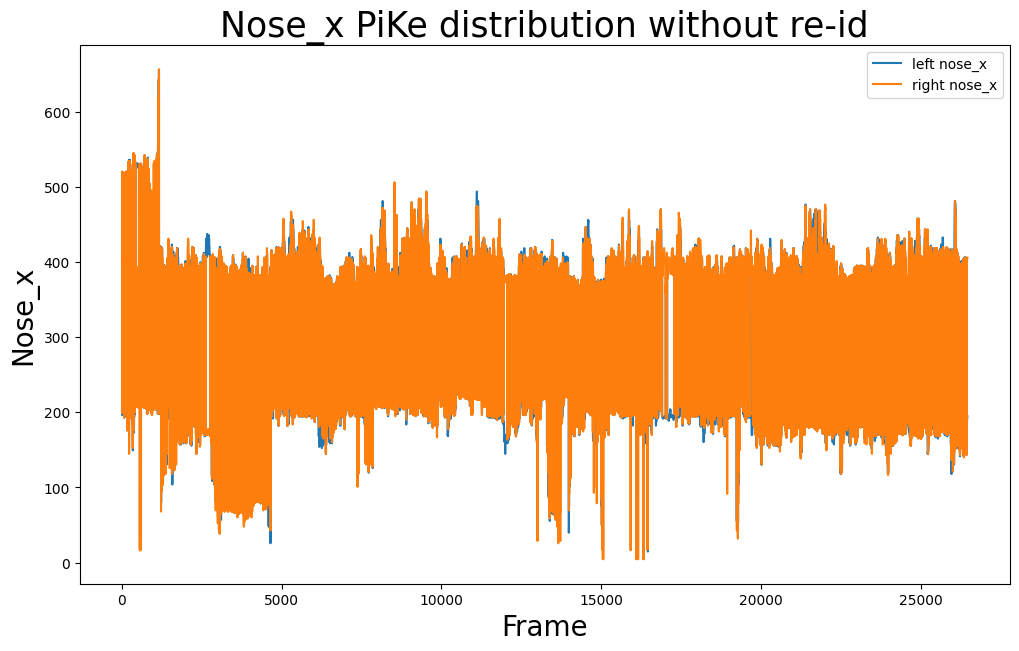

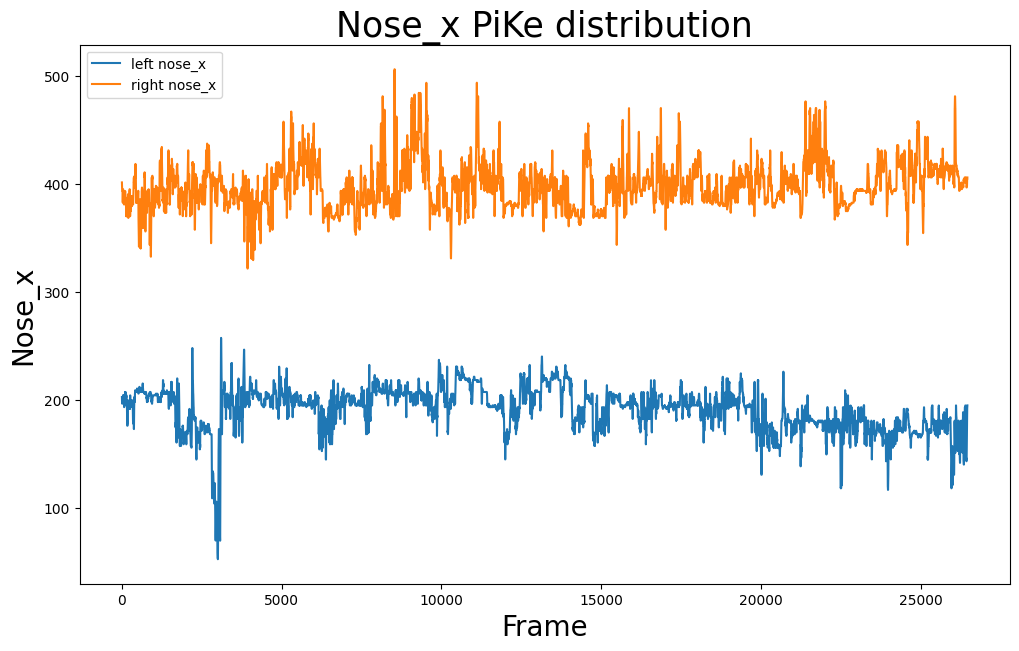

In [14]:
path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/PiKe4jan7_keypoint'
elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/PiKe4jan7_11juli17_TU.eaf'
file_name = 'PiKe'

# path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/KN5Jan7_keypoint'
# elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/KN5jan7_12sep2017TU.eaf'
# file_name = 'KN'

# path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/ReKe10Jan7_keypoint'
# elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/ReKe10jan7_20012016.eaf'
# file_name = 'ReKe'

# path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/SuJu16jan7_keypoint'
# elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/SuJu16jan7_11juli17.eaf'
# file_name = 'SuJu'



# path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/PiKe_R7_keypoint'
# elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/PiKe4jan7_11juli17_TU.eaf'
# file_name = 'PiKe_R7'

# path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/KN_R8_keypoint'
# elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/KN5jan7_12sep2017TU.eaf'
# file_name = 'KN_R8'

# path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/ReKe_R6_keypoint'
# elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/ReKe10jan7_20012016.eaf'
# file_name = 'ReKe_R6'

# path_to_json = '/Users/zhoudachuan/Desktop/thesis/code/openpose_output/SuJu_R6_keypoint'
# elan_file_path = '/Users/zhoudachuan/Desktop/thesis/sign_language_dataset/SuJu16jan7_11juli17.eaf'
# file_name = 'SuJu_R6'


output_path = '/Users/zhoudachuan/Desktop/thesis/code/clean_df_standard'
Tx = 100
Flip = False

left_df, right_df = preprocess(path_to_json, elan_file_path, output_path, file_name, Tx, Flip)